In [1]:
import chess
import torch
import numpy as np
from typing import Literal, Union, List, Tuple


class MatrixEncoder:
    def encode(self, board: chess.Board) -> np.ndarray:
        # 12 каналов для фигур
        board_state = np.zeros((12, 8, 8), dtype=np.float32)

        # 1. Кодируем состояние доски
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece is not None:
                # Определяем канал:
                # 0-5: пешка, конь, слон, ладья, ферзь, король
                channel = piece.piece_type - 1
                if piece.color == chess.BLACK:
                    channel += 6
                row = square // 8
                col = square % 8
                board_state[channel, row, col] = 1.0

#         # 2. Дополнительные признаки
#         if board.has_kingside_castling_rights(chess.WHITE):
#             board_state[12][7, 4] = 1.0  # Король белых на e1
#         if board.has_queenside_castling_rights(chess.WHITE):
#             board_state[12][7, 4] = 1.0  # Король белых на e1
#         if board.has_kingside_castling_rights(chess.BLACK):
#             board_state[12][7, 0] = -1.0  # Король чёрных на e8
#         if board.has_queenside_castling_rights(chess.BLACK):
#             board_state[12][7, 0] = -1.0  # Король чёрных на e8

#         if board.ep_square is not None:
#             ep_row = board.ep_square // 8
#             ep_col = board.ep_square % 8
#             board_state[13][ep_row, ep_col] = 1.0

#         if board.peek() and board.peek().promotion is None:
#             last_move = board.peek()
#             if abs(last_move.from_square - last_move.to_square) == 16:  # Ход на две клетки
#                 double_move_row = last_move.to_square // 8
#                 double_move_col = last_move.to_square % 8
#                 board_state[14][double_move_row, double_move_col] = 1.0

        return board_state

    def get_encoded_shape(self):
        return (12, 8, 8)

In [2]:
import torch
import torch.nn as nn


class BinaryClassifierTransformer(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=8, num_layers=8, dim_feedforward=256, dropout=0.1):
        super().__init__()
        
        # 1. Улучшенный embedding слой
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU()
        )
        
        # 2. Позиционные эмбеддинги
        self.pos_encoder = nn.Parameter(torch.randn(1, 200, d_model))
        
        # 3. Увеличенный трансформер
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 4. Расширенный классификатор
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, 1)
        )
        
        # Инициализация весов
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer(x)
        return torch.sigmoid(self.classifier(x)).squeeze(-1)  # [batch_size, seq_len]

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class Board2Vec(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        # Входной блок с 12 каналов (6 фигур × 2 цвета + информация про рокировку, взятие на проходе и promotion)
        self.initial = nn.Sequential(
            nn.Conv2d(12, hidden_dim, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True)
        )

        # Резидуальные блоки
        self.block1 = ResidualBlock(hidden_dim)
        self.block2 = ResidualBlock(hidden_dim)
        self.block3 = ResidualBlock(hidden_dim)

        # Глобальный пуллинг и финальные слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, boards: torch.Tensor):
        # boards: (batch_size, 12, 8, 8)
        x = self.initial(boards)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Конкатенация с дополнительными признаками
        x = self.fc(x)
        return x

In [4]:
import chess.pgn
import numpy as np

def pgn_to_tensors(pgn_path, encoder):
    """
    Преобразует единственную партию из PGN-файла в список тензоров (закодированных досок)
    
    Аргументы:
        pgn_path: str - путь к PGN-файлу с одной партией
        encoder - кодировщик досок (должен иметь метод encode)
        
    Возвращает:
        list[np.ndarray] - список закодированных досок для каждого хода партии
    """
    with open(pgn_path) as pgn_file:
        game = chess.pgn.read_game(pgn_file)
        if game is None:
            raise ValueError("PGN файл не содержит партий или пуст")
            
        # Проверяем, что в файле только одна партия
        if chess.pgn.read_game(pgn_file) is not None:
            raise ValueError("PGN файл содержит более одной партии")
            
        board = game.board()
        moves = list(game.mainline_moves())
        encoded_boards = []
        
        # Кодируем начальную позицию
        encoded_boards.append(encoder.encode(board))
        
        # Кодируем позиции после каждого хода
        for move in moves:
            board.push(move)
            encoded_boards.append(encoder.encode(board))
            
        return encoded_boards


In [63]:
tensors = pgn_to_tensors("C:/Users/matvey/Documents/chess_data/dataset_for_comparsion/nwTYPU4d.pgn", MatrixEncoder())
print(f"Получено {len(tensors)} закодированных досок")

Получено 57 закодированных досок


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
board2vec = Board2Vec(128, 64)
board2vec.load_state_dict(torch.load('checkpoints/board2vec_epoch1.pt', map_location=device))
board2vec.eval()
embeds = np.array([board2vec(torch.tensor(x).unsqueeze(0)).detach().numpy() for x in tensors]).reshape((len(tensors), 64))
embeds.shape

(57, 64)

In [66]:
# Паддинг
if len(tensors) < 200:
    pad = torch.zeros(200 - len(tensors), embeds.shape[1])
    embeds = torch.cat([torch.FloatTensor(embeds), pad])
else:
    embeds = torch.FloatTensor(embeds[:200])

In [67]:
model = BinaryClassifierTransformer(64).to(device)
model.load_state_dict(torch.load('checkpoints/transformer_epoch50.pt', map_location=device))

<All keys matched successfully>

In [68]:
result = model(torch.tensor(embeds))[0][:len(tensors)].detach().numpy()

C:\Users\matvey\AppData\Local\Temp\ipykernel_10308\3542970296.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = model(torch.tensor(embeds))[0][:len(tensors)].detach().numpy()


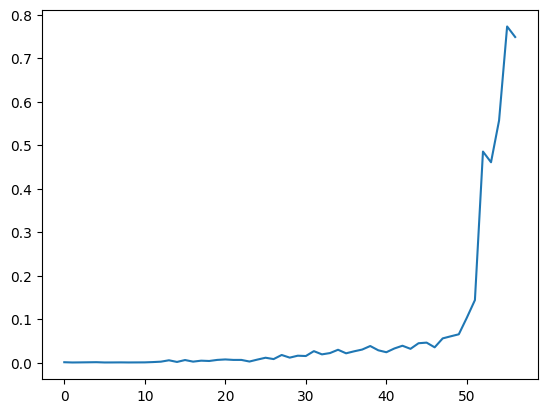

In [69]:
import matplotlib.pyplot as plt

plt.plot(result)
plt.show()

In [73]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths


from scipy.signal import find_peaks
from scipy.signal import peak_widths
import numpy as np

def inference(y_pred):
    # Применяем сглаживание
    kernel = np.ones(5) / 5
    smoothed = np.convolve(y_pred, kernel, mode='same')
    
    threshold = np.percentile(smoothed, 70)
    peaks, _ = find_peaks(smoothed, height=threshold, distance=10)
    
    # Если пики не найдены, используем простой порог
    if len(peaks) == 0:
        y_result = (smoothed > threshold).astype(int)
        return y_result
    
    rel_heights = np.minimum(1, smoothed[peaks] * 8)
    widths_list, left_ips_list, right_ips_list = [], [], []
    
    for i, peak in enumerate(peaks):
        w, _, l, r = peak_widths(smoothed, [peak], rel_height=rel_heights[i])
        widths_list.append(w[0])
        left_ips_list.append(l[0])
        right_ips_list.append(r[0])
    
    widths = np.array(widths_list)
    left_ips = np.array(left_ips_list)
    right_ips = np.array(right_ips_list)
    
    valid_mask = (widths > 4) & (widths < 50)
    left_ips = left_ips[valid_mask]
    right_ips = right_ips[valid_mask]
    
    y_result = np.zeros_like(y_pred)
    
    left_bounds = np.floor(left_ips).astype(int)
    right_bounds = np.ceil(right_ips).astype(int) + 1
    
    for start, end in zip(left_bounds, right_bounds):
        y_result[start:end] = 1
    
    # Дополнительная проверка: если после всех фильтров остались нули
    # возвращаем результат по порогу
    if np.sum(y_result) == 0:
        threshold = np.percentile(smoothed, 80)
        y_result = (smoothed > threshold).astype(int)
    
    return y_result

In [74]:
y_result = inference(result)

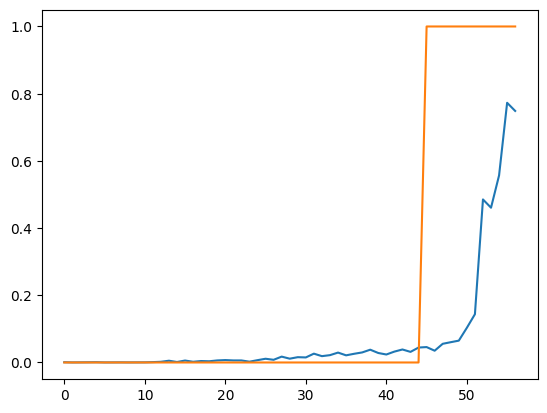

In [75]:
import matplotlib.pyplot as plt

plt.plot(result)
plt.plot(y_result)
plt.show()

In [76]:
import numpy as np

def find_longest_segment_of_ones(arr):
    # Находим индексы, где происходят переходы между 0 и 1
    changes = np.diff(np.concatenate(([0], arr, [0])))
    
    # Начала отрезков (индексы, где 0 переходит в 1)
    starts = np.where(changes == 1)[0]
    # Концы отрезков (индексы, где 1 переходит в 0)
    ends = np.where(changes == -1)[0]
    
    # Если нет отрезков из единиц, возвращаем (0, 0)
    if len(starts) == 0:
        return (0, 0)
    
    # Находим самый длинный отрезок
    lengths = ends - starts
    longest_idx = np.argmax(lengths)
    
    return (starts[longest_idx], ends[longest_idx])

In [77]:
find_longest_segment_of_ones(y_result)

(np.int64(45), np.int64(57))

In [78]:
import csv
csv_file = 'C:/Users/matvey/Documents/chess_data/dataset_for_comparsion/_info.csv'
with open(csv_file, mode='r', encoding='utf-8') as file:
    lol = list(csv.DictReader(file))
# reader = list(csv.DictReader(file))[200:400]
kek = lol[:100] + lol[200:400] + lol[400:500]

In [80]:
import pandas as pd

comp_path = 'C:/Users/matvey/workspace/FriflexChess/highlighter/comparsion.csv'

with open(comp_path, encoding='utf-8') as file:
    lines = [i.strip() for i in file.readlines()]
    lines[0] = 'start_dataset,end_dataset,start_llm,end_llm,start_transformer,end_transformer'
    cnt = 1
    for i in kek:
        path = i['path_to_pgn']
        start, end = map(int, i['marks'].split(','))
        tensors = pgn_to_tensors(path, MatrixEncoder())  # Исправлено path_to_pgn на path
        embeds = np.array([board2vec(torch.tensor(x).unsqueeze(0)).detach().numpy() for x in tensors]).reshape((len(tensors), 64))
        # Паддинг
        if len(tensors) < 200:
            pad = torch.zeros(200 - len(tensors), embeds.shape[1])
            embeds = torch.cat([torch.FloatTensor(embeds), pad])
        else:
            embeds = torch.FloatTensor(embeds[:200])
        result = model(torch.tensor(embeds))[0][:len(tensors)].detach().numpy()
        y_res = inference(result)
        tr_s, tr_e = find_longest_segment_of_ones(y_res)
        # asd.append((tr_s, tr_e))
        lines[cnt] += f',{tr_s},{tr_e}'

        # print(tr_s, tr_e)
        cnt += 1
        print(cnt, end='\r')

with open('comparsion2.csv', 'w', encoding='utf-8') as file:
    file.write('\n'.join(lines))


C:\Users\matvey\AppData\Local\Temp\ipykernel_10308\1540879712.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = model(torch.tensor(embeds))[0][:len(tensors)].detach().numpy()
